In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from rom_am import *
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate as si

## Creating the snapshots

In [2]:
with open("../DATA/Piezo/with_accel/press_data.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    pres = np.loadtxt(lines, delimiter=',',)
with open("../DATA/Piezo/with_accel/meshx_data.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    meshx = np.loadtxt(lines, delimiter=',',)
with open("../DATA/Piezo/with_accel/meshy_data.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    meshy = np.loadtxt(lines, delimiter=',',)
with open("../DATA/Piezo/with_accel/vx_data.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    vx = np.loadtxt(lines, delimiter=',',)
with open("../DATA/Piezo/with_accel/vy_data.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    vy = np.loadtxt(lines, delimiter=',',)
with open("../DATA/Piezo/with_accel/solid_accel_x.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    uddot_x = np.loadtxt(lines, delimiter=',',)    
with open("../DATA/Piezo/with_accel/solid_accel_y.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    uddot_y = np.loadtxt(lines, delimiter=',',)
with open("../DATA/Piezo/with_accel/solid_disp_x.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    u_x = np.loadtxt(lines, delimiter=',',)    
with open("../DATA/Piezo/with_accel/solid_disp_y.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    u_y = np.loadtxt(lines, delimiter=',',)
coor = pd.read_csv('../DATA/Piezo/coordinates.csv', sep=' |,|[|]', 
                  engine='python', header=None, skiprows=1).to_numpy()[:, :4]
coor = coor[np.argsort(coor[:, 0]), :]

## Time and geometric shape
ntt = pres.shape[1]
nxx = pres.shape[0]
dt = 2e-2
data_t = np.arange(0, ntt)*dt
t1 = 0

# Time domain for solid is different
s_ntt = u_x.shape[1]
s_dt = 3e-2
s_data_t = np.arange(0, s_ntt)*s_dt
u_x = si.griddata(s_data_t, u_x.T, data_t, method='linear').T
u_y = si.griddata(s_data_t, u_y.T, data_t, method='linear').T
uddot_x = si.griddata(s_data_t, uddot_x.T, data_t, method='linear').T
uddot_y = si.griddata(s_data_t, uddot_y.T, data_t, method='linear').T

## Coordinates of the reference mesh
x = coor[:, 1]
y = coor[:, 2]

## Indices of nodes at the positive normal Z face
z_pos_id = np.isclose(coor[:, -1], 0.025)
z_pos_coor = coor[z_pos_id, :]
x_z_pos = z_pos_coor[:, 1]
y_z_pos = z_pos_coor[:, 2]

In [3]:
data = np.vstack((pres, vx, vy, meshx, meshy, u_x, u_y, uddot_x, uddot_y)) # Input data

## Taking a fraction of data for training
Coeff = .8
X = data[:, :-1][:, :int(ntt*Coeff)]
Y = data[:, 1::][:, :int(ntt*Coeff)]
training_t = data_t[:int(ntt*Coeff)]

## The rest for testing
X_test = data[:, :-1][:, int(ntt*Coeff)::]
Y_test = data[:, 1::][:, int(ntt*Coeff)::]

## DMD Reduction

In [43]:
dmd = DMD()
drom = ROM(dmd)
drom.decompose(X,  Y = Y, dt = dt, sorting = "abs", normalize=True, normalization = "minmax", opt_trunc=True)

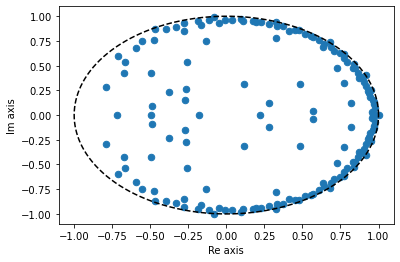

In [31]:
plt.plot(np.real(drom.model.lambd), np.imag(drom.model.lambd), '.', markersize = 13);
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

## DMD Prediction

In [39]:
pred_t = np.concatenate((data_t, data_t[:int(.6 * ntt)] + data_t[-1]))
prediction = np.real(drom.predict(pred_t, method=0, t1=t1,))

## Extract predicted fields
pred_pres = prediction[:nxx, :]
pred_vx = prediction[nxx:2*nxx, :]
pred_vy = prediction[2*nxx:3*nxx, :]
pred_meshx = prediction[3*nxx:4*nxx, :]
pred_meshy = prediction[4*nxx:5*nxx, :]

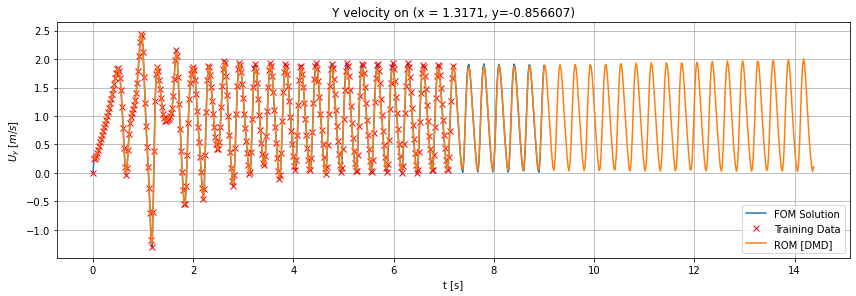

In [33]:
id_ = 5000

figure = plt.figure(figsize = (12, 4))
plt.plot(data_t, vy[id_, :], label = "FOM Solution");
plt.plot(training_t, vy[id_, :int(ntt * Coeff)], 'xr', label = "Training Data");
plt.plot(pred_t[1::], pred_vy[id_, :][1::], label = "ROM [DMD]");
plt.grid();
plt.xlabel("t [s]");
plt.ylabel(r"$U_y \;[m/s]$");
plt.legend();
plt.tight_layout();
plt.title("Y velocity on (x = "+str(x[id_])+", y="+str(y[id_])+")");

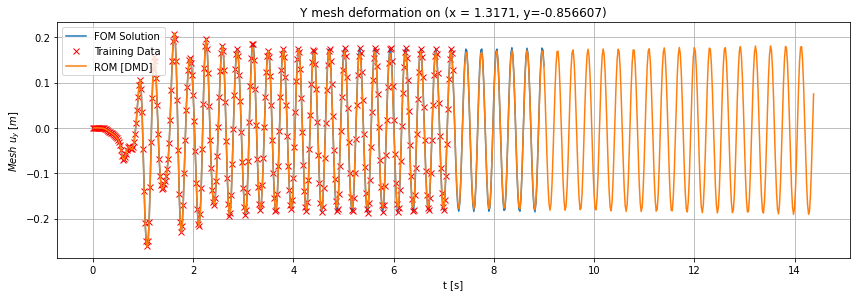

In [34]:
id_ = 5000

figure = plt.figure(figsize = (12, 4))
plt.plot(data_t, meshy[id_, :], label = "FOM Solution");
plt.plot(training_t, meshy[id_, :int(ntt * Coeff)], 'xr', label = "Training Data");
plt.plot(pred_t[1::], pred_meshy[id_, :][1::], label = "ROM [DMD]");
plt.grid();
plt.xlabel("t [s]");
plt.ylabel(r"$Mesh \; u_y \;[m]$");
plt.legend();
plt.tight_layout();
plt.title("Y mesh deformation on (x = "+str(x[id_])+", y="+str(y[id_])+")");

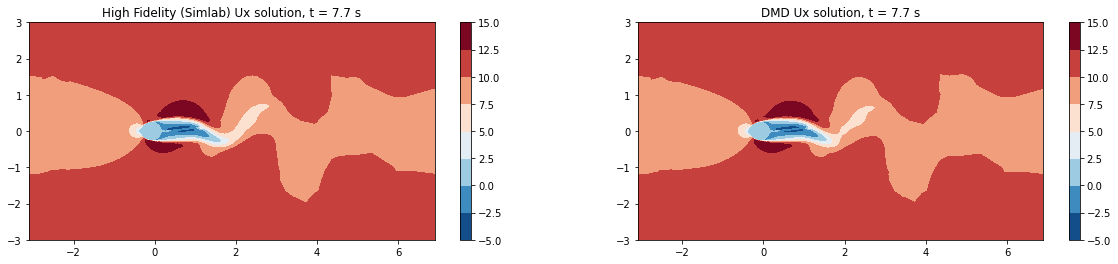

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
instant = int(ntt*Coeff) + 25

vmin = min(vx[z_pos_id, instant].min(), pred_vx[z_pos_id, instant].min())
vmax = max(vx[z_pos_id, instant].max(), pred_vx[z_pos_id, instant].max())

curr_x = x_z_pos+meshx[z_pos_id, instant]
curr_y = y_z_pos+meshy[z_pos_id, instant]
c0 = ax[0].tricontourf(curr_x, curr_y, vx[z_pos_id, instant], cmap='RdBu_r', vmin=vmin, vmax=vmax);
plt.colorbar(c0, ax=ax[0]);
ax[0].set_title("High Fidelity (Simlab) Ux solution, t = "+str(data_t[instant])+" s");

curr_x = x_z_pos+pred_meshx[z_pos_id, instant]
curr_y = y_z_pos+pred_meshy[z_pos_id, instant]
c1 = ax[1].tricontourf(curr_x, curr_y, pred_vx[z_pos_id, instant], vmin=vmin, vmax=vmax, cmap='RdBu_r',);
plt.colorbar(c0, ax=ax[1]);
ax[1].set_title("DMD Ux solution, t = "+str(data_t[instant])+" s");

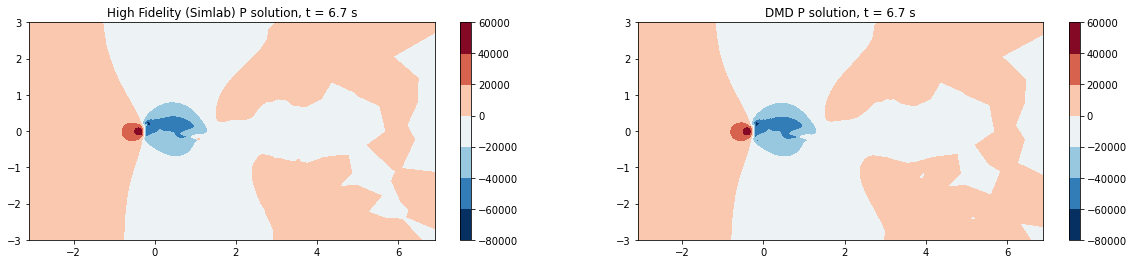

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
instant = int(ntt*Coeff) -25

vmin = min(pres[z_pos_id, instant].min(), pred_pres[z_pos_id, instant].min())
vmax = max(pres[z_pos_id, instant].max(), pred_pres[z_pos_id, instant].max())

curr_x = x_z_pos+meshx[z_pos_id, instant]
curr_y = y_z_pos+meshy[z_pos_id, instant]
c0 = ax[0].tricontourf(curr_x, curr_y, pres[z_pos_id, instant], cmap='RdBu_r', vmin=vmin, vmax=vmax);
plt.colorbar(c0, ax=ax[0]);
ax[0].set_title("High Fidelity (Simlab) P solution, t = "+str(data_t[instant])+" s");

curr_x = x_z_pos+pred_meshx[z_pos_id, instant]
curr_y = y_z_pos+pred_meshy[z_pos_id, instant]
c1 = ax[1].tricontourf(curr_x, curr_y, pred_pres[z_pos_id, instant], vmin=vmin, vmax=vmax, cmap='RdBu_r',);
plt.colorbar(c0, ax=ax[1]);
ax[1].set_title("DMD P solution, t = "+str(data_t[instant])+" s");

In [ ]:
pred_ux = prediction[6*nxx:7*nxx, :]
pred_uy = prediction[7*nxx:8*nxx, :]

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
instant = int(ntt*Coeff) + 25

vmin = min(pred_ux[z_pos_id, instant].min(), pred_ux[z_pos_id, instant].min())
vmax = max(pred_uy[z_pos_id, instant].max(), pred_uy[z_pos_id, instant].max())

curr_x = x_z_pos+meshx[z_pos_id, instant]
curr_y = y_z_pos+meshy[z_pos_id, instant]
c0 = ax[0].tricontourf(curr_x, curr_y, vx[z_pos_id, instant], cmap='RdBu_r', vmin=vmin, vmax=vmax);
plt.colorbar(c0, ax=ax[0]);
ax[0].set_title("High Fidelity (Simlab) Ux solution, t = "+str(data_t[instant])+" s");

curr_x = x_z_pos+pred_meshx[z_pos_id, instant]
curr_y = y_z_pos+pred_meshy[z_pos_id, instant]
c1 = ax[1].tricontourf(curr_x, curr_y, pred_vx[z_pos_id, instant], vmin=vmin, vmax=vmax, cmap='RdBu_r',);
plt.colorbar(c0, ax=ax[1]);
ax[1].set_title("DMD Ux solution, t = "+str(data_t[instant])+" s");

In [44]:
print("Training time : ", drom.profile["Training time"], " s")

Training time :  11.059980154037476  s


In [40]:
print("Prediction time : ", drom.profile["Prediction time"], " s")

Prediction time :  6.164039611816406  s


**Saving plots (optional)**

In [ ]:
for i in range(len(pred_t)):
    
    col = "k"
    fig, ax = plt.subplots(1, 2, figsize=(20, 4))
    instant = i
    if instant >= len(data_t):
        col = "g"

    vmin = pred_vx[z_pos_id, instant].min()
    vmax = pred_vx[z_pos_id, instant].max()
    
    if instant < len(data_t): 
        vmin = min(vx[z_pos_id, instant].min(), pred_vx[z_pos_id, instant].min())
        vmax = max(vx[z_pos_id, instant].max(), pred_vx[z_pos_id, instant].max())
        
        curr_x = x_z_pos+meshx[z_pos_id, instant]
        curr_y = y_z_pos+meshy[z_pos_id, instant]
        c0 = ax[0].tricontourf(curr_x, curr_y, vx[z_pos_id, instant], cmap='RdBu_r', vmin=vmin, vmax=vmax);
        plt.colorbar(c0, ax=ax[0]);
        ax[0].set_title("High Fidelity (Simlab) Ux solution, t = "+str(data_t[instant])+" s");
        
        if instant == len(data_t)-1:
            vmin_store = vmin
            vmax_store = vmax
            curr_x_store = curr_x.copy()
            curr_y_store = curr_y.copy()
            store_z = vx[z_pos_id, instant]
    else:
        c0 = ax[0].tricontourf(curr_x_store, curr_y_store, store_z, cmap='RdBu_r', vmin=vmin_store, vmax=vmax_store);
        plt.colorbar(c0, ax=ax[0]);
        ax[0].set_title("High Fidelity (Simlab) Ux solution, t = "+str(data_t[-1])+" s");

    curr_x = x_z_pos+pred_meshx[z_pos_id, instant]
    curr_y = y_z_pos+pred_meshy[z_pos_id, instant]
    c1 = ax[1].tricontourf(curr_x, curr_y, pred_vx[z_pos_id, instant], vmin=vmin, vmax=vmax, cmap='RdBu_r');
    plt.colorbar(c0, ax=ax[1]);
    ax[1].set_title("DMD U solution, t = "+str(pred_t[instant])+" s", {"color" : col});

    fig.savefig("../References/Piezo/u_dmd_"+str(i)+".png", bbox_inches = 'tight');

**Separating two ROMs**

- ROM1 : Transient system

In [25]:
index_stop = (data_t > 2.5).nonzero()[0][0]

In [26]:
## Taking a fraction of data for training
Coeff = .8
X2 = data[:, :-1][:, index_stop:int(ntt*Coeff)]
Y2 = data[:, 1::][:, index_stop:int(ntt*Coeff)]
training_t2 = data_t[index_stop:int(ntt*Coeff)]
t2 = training_t2[0]

## The rest for testing
X_test2 = data[:, :-1][:, int(ntt*Coeff)::]
Y_test2 = data[:, 1::][:, int(ntt*Coeff)::]

In [27]:
dmd2 = DMD()
drom2 = ROM(dmd2)
drom2.decompose(X2,  Y = Y2, dt = dt, sorting = "abs", normalize=True, opt_trunc=True)

In [28]:
pred_t2 = np.concatenate((data_t[index_stop::], data_t[index_stop::] + data_t[-1] - data_t[index_stop::][0]))
prediction2 = np.real(drom2.predict(pred_t2, method=0, t1=t2,))

## Extract predicted fields
pred_pres = prediction2[:nxx, :]
pred_vx = prediction2[nxx:2*nxx, :]
pred_vy = prediction2[2*nxx:3*nxx, :]
pred_meshx = prediction2[3*nxx:4*nxx, :]
pred_meshy = prediction2[4*nxx:5*nxx, :]

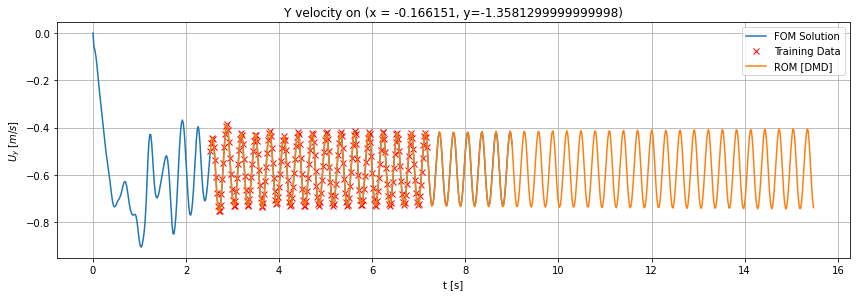

In [29]:
id_ = 1504

figure = plt.figure(figsize = (12, 4))
plt.plot(data_t, vy[id_, :], label = "FOM Solution");
plt.plot(training_t2, vy[id_, index_stop:int(ntt * Coeff)], 'xr', label = "Training Data");
plt.plot(pred_t2, pred_vy[id_, :], label = "ROM [DMD]");
plt.grid();
plt.xlabel("t [s]");
plt.ylabel(r"$U_y \;[m/s]$");
plt.legend();
plt.tight_layout();
plt.title("Y velocity on (x = "+str(x[id_])+", y="+str(y[id_])+")");